In [1]:
import pandas            as pd
import missingno         as msno
import seaborn           as sns
import matplotlib.pyplot as plt
import statsmodels.api   as sm
import scipy.stats       as stats

# Data Wrangling

In [2]:
# Import dataset into Pandas DataFrame
df_raw    = pd.read_csv("../dat/ship_data.csv")
n_records = df_raw.shape[0]

# Check column names and data types
print(df_raw.shape)
df_raw.info()

(16248, 26)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16248 entries, 0 to 16247
Data columns (total 26 columns):
Time                                                          16248 non-null int64
Main Engine Fuel Consumption (MT/day)                         16085 non-null float64
Main Engine Using HFO (bool)                                  16085 non-null float64
Main Engine Using MGO (bool)                                  16085 non-null float64
Draft Forward (meters)                                        16085 non-null float64
Draft Aft (meters)                                            16085 non-null float64
Draft Mid-1 (meters)                                          16085 non-null float64
Draft Mid-2 (meters)                                          16085 non-null float64
Shaft Speed (RPM)                                             16085 non-null float64
Shaft Torque (kNm)                                            16085 non-null float64
Shaft Power (kW)               

### Missing Records

Time                                                            0
Main Engine Fuel Consumption (MT/day)                         163
Main Engine Using HFO (bool)                                  163
Main Engine Using MGO (bool)                                  163
Draft Forward (meters)                                        163
Draft Aft (meters)                                            163
Draft Mid-1 (meters)                                          163
Draft Mid-2 (meters)                                          163
Shaft Speed (RPM)                                             163
Shaft Torque (kNm)                                            163
Shaft Power (kW)                                              163
Speed Over Ground (knots)                                     163
Speed Through Water (knots)                                   163
Heading (degrees)                                               8
Rudder Angle (degrees)                                        163
Weather Se

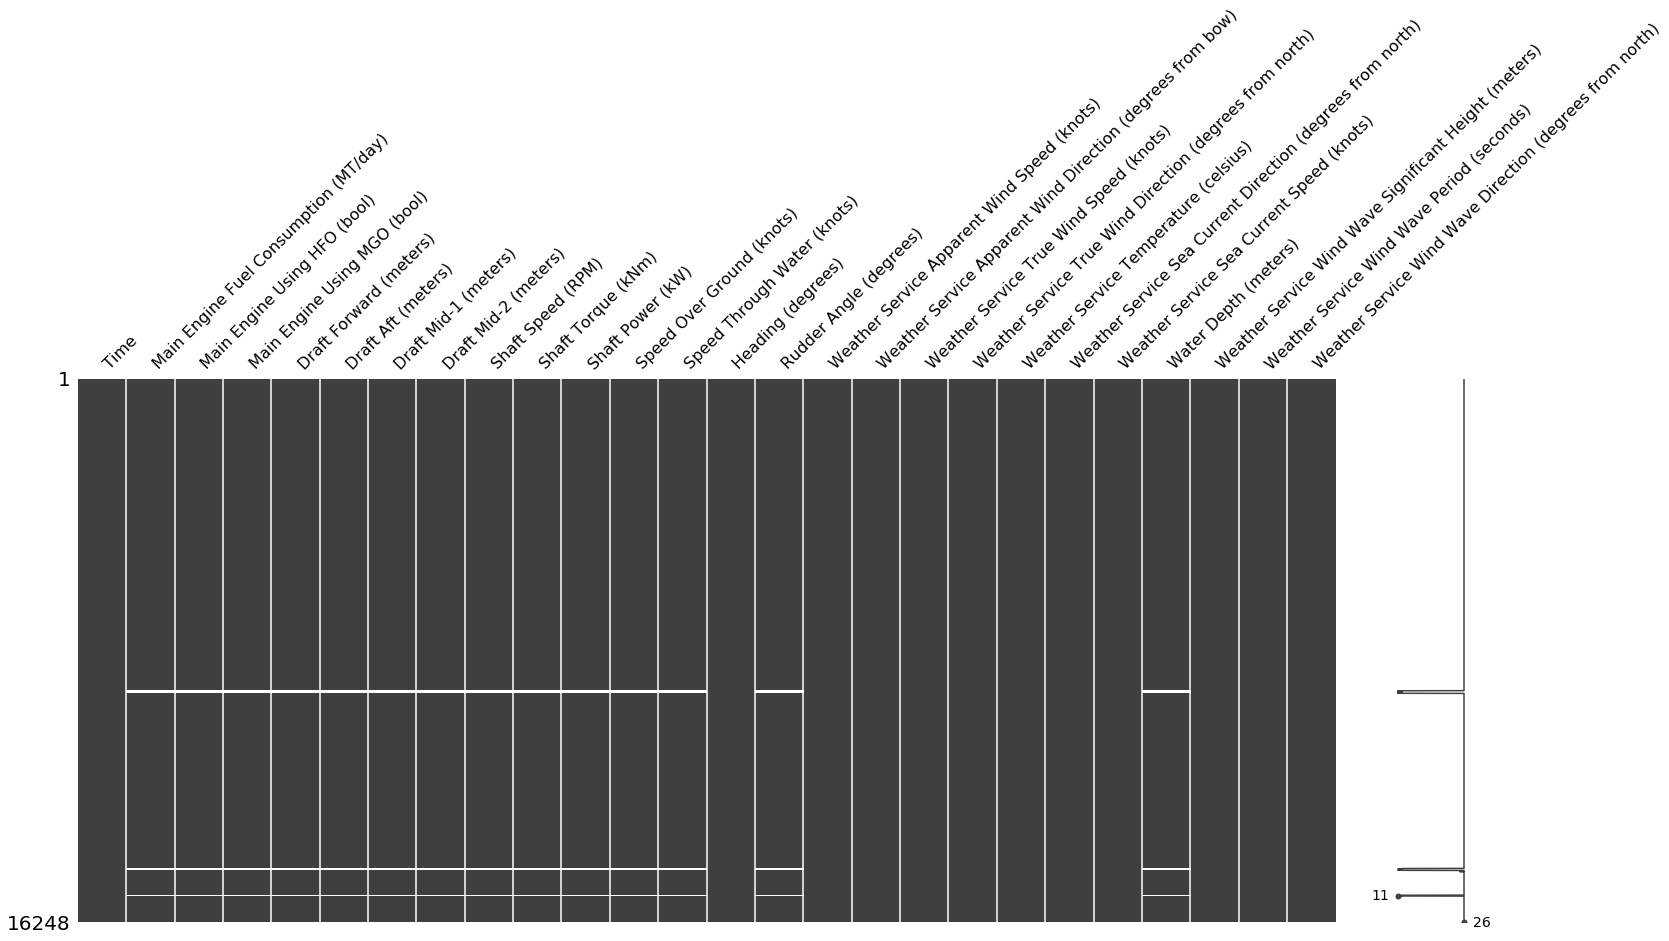

In [3]:
# Check missing values
print(df_raw.isnull().sum())
msno.matrix(df_raw)

1.0093549975381588


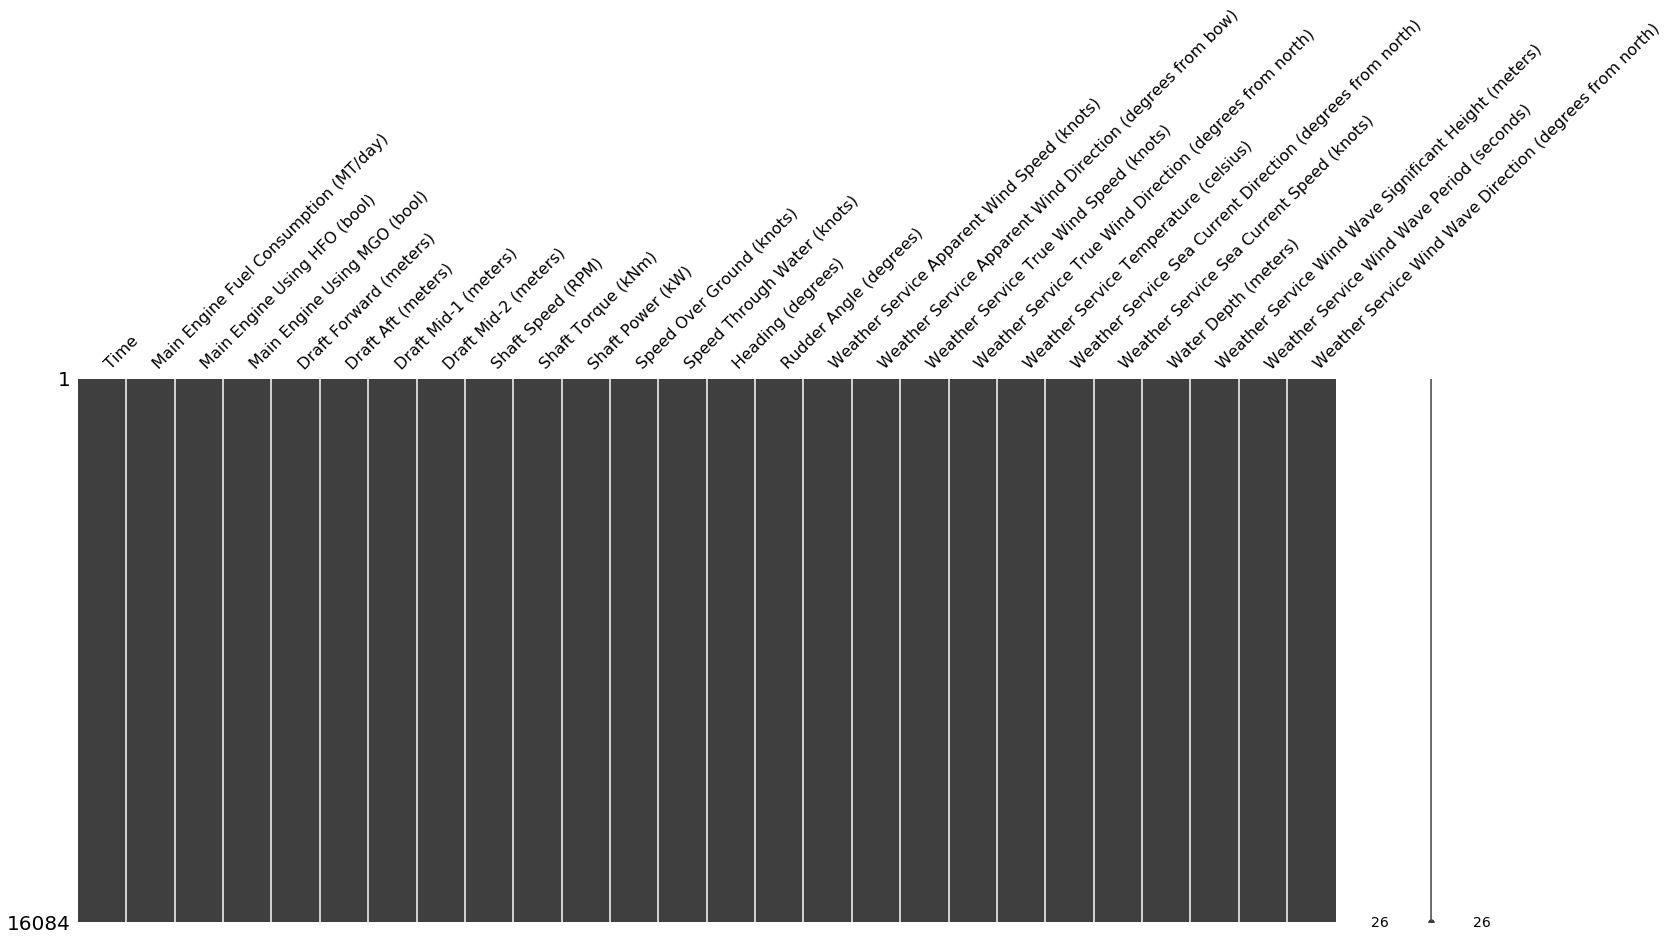

In [4]:
# Drop rows with missing target ~ 1% of records
df_mod = df_raw.copy().dropna()
print((1 - df_mod.shape[0] / n_records) * 100)
msno.matrix(df_mod)

### Time Series Visualization

In [5]:
# Create helper sublists of column names
cols_main  = df_mod.columns[0:4]
cols_draft = df_mod.columns[4:8]
cols_shaft = df_mod.columns[8:11]
cols_speed = df_mod.columns[11:15]
cols_wind  = df_mod.columns[15:19]
cols_sea   = df_mod.columns[19:23]
cols_wave  = df_mod.columns[23:26]
df_mod.shape

(16084, 26)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c1e31b940>,
      dtype=object)

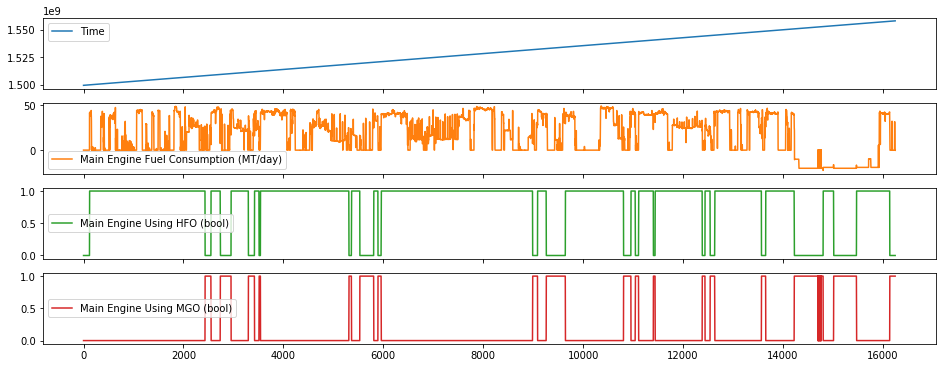

In [6]:
# Time and main engine
fig_main, axes_main = plt.subplots(len(cols_main),1, figsize=(16,len(cols_main)*1.5), sharex=True)
df_mod[cols_main].plot(subplots=True, ax=axes_main)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c22e2c128>,
      dtype=object)

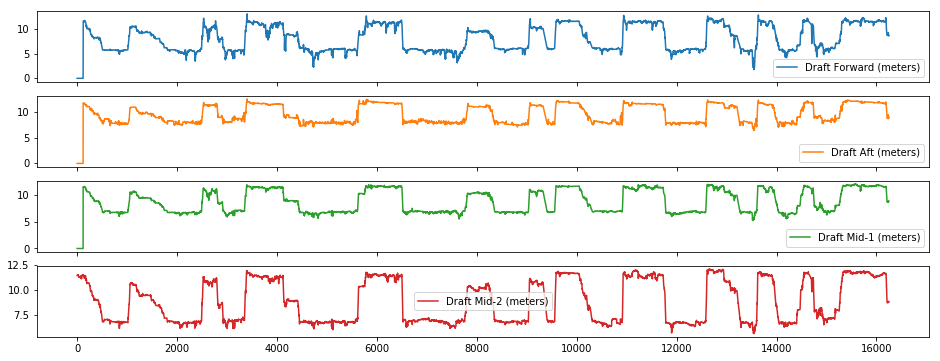

In [7]:
# Draft sensors
fig_draft, axes_draft = plt.subplots(len(cols_draft),1, figsize=(16,len(cols_draft)*1.5), sharex=True)
df_mod[cols_draft].plot(subplots=True, ax=axes_draft)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c1d7c9fd0>,
      dtype=object)

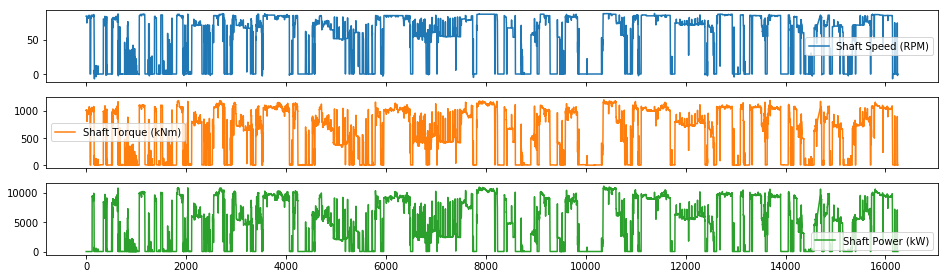

In [8]:
# Shaft performance
fig_shaft, axes_shaft = plt.subplots(len(cols_shaft),1, figsize=(16,len(cols_shaft)*1.5), sharex=True)
df_mod[cols_shaft].plot(subplots=True, ax=axes_shaft)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c2090a2b0>,
      dtype=object)

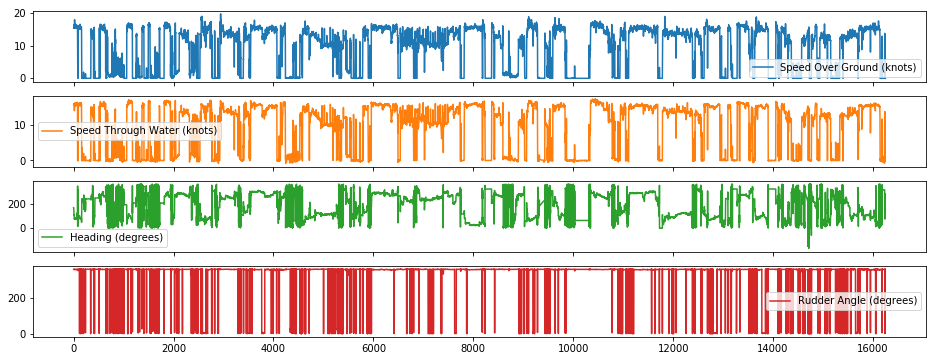

In [9]:
# Vessel speed
fig_speed, axes_speed = plt.subplots(len(cols_speed),1, figsize=(16,len(cols_speed)*1.5), sharex=True)
df_mod[cols_speed].plot(subplots=True, ax=axes_speed)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c20743a58>,
      dtype=object)

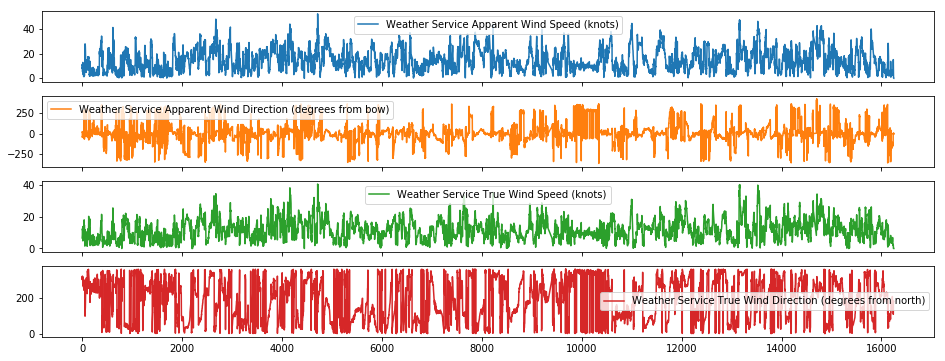

In [10]:
# Wind conditions
fig_wind, axes_wind = plt.subplots(len(cols_wind),1, figsize=(16,len(cols_wind)*1.5), sharex=True)
df_mod[cols_wind].plot(subplots=True, ax=axes_wind)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c21b39a90>,
      dtype=object)

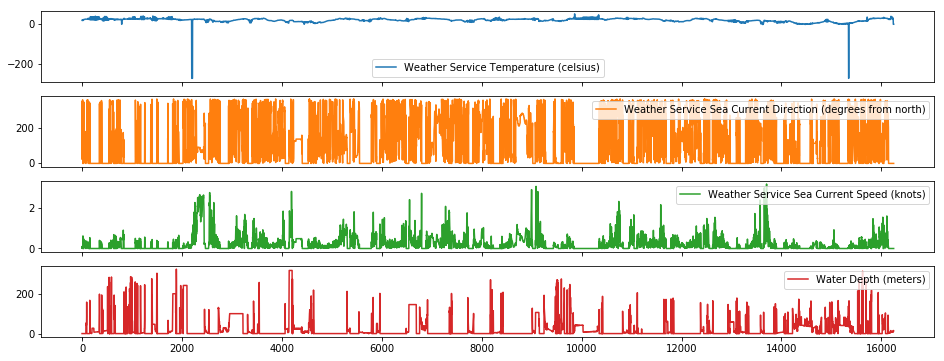

In [11]:
# Sea conditions
fig_sea, axes_sea = plt.subplots(len(cols_sea),1, figsize=(16,len(cols_sea)*1.5), sharex=True)
df_mod[cols_sea].plot(subplots=True, ax=axes_sea)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c226b7080>,
      dtype=object)

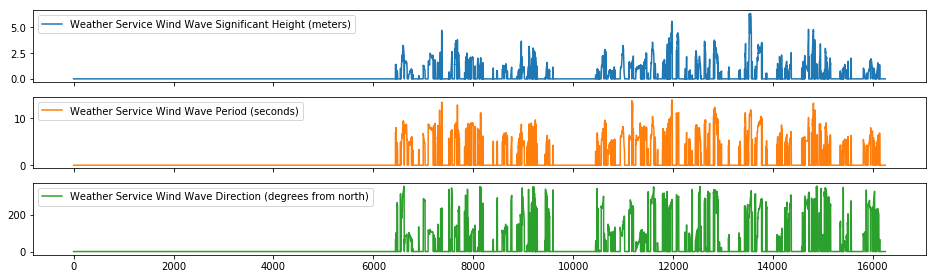

In [12]:
# Wave conditions
fig_wave, axes_wave = plt.subplots(len(cols_wave),1, figsize=(16,len(cols_wave)*1.5), sharex=True)
df_mod[cols_wave].plot(subplots=True, ax=axes_wave)

### Data Cleaning

In [13]:
# Convert Unix time to datetime format
df_mod['Time'] = pd.to_datetime(df_mod['Time'], unit = 's')
df_mod['Time'].head()

0   2017-07-06 13:15:00
1   2017-07-06 14:00:00
2   2017-07-06 15:00:00
3   2017-07-06 16:00:00
4   2017-07-06 17:00:00
Name: Time, dtype: datetime64[ns]

-0.048000     2105
-20.193103     829
-19.200000     617
-0.050483      526
 0.000000      149
Name: Main Engine Fuel Consumption (MT/day), dtype: int64


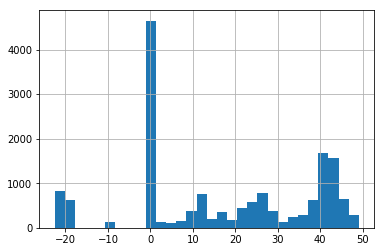

In [14]:
# Investigate negative fuel consumption
print(df_mod[cols_main[1]].value_counts().head())

# Plot frequency distribution of fuel consumption
df_mod[cols_main[1]].hist(bins=30)

In [15]:
# Calibrate fuel consumption with most frequent near-zero measurement (-0.048 MT/day)
zero_offset          = df_mod[cols_main[1]].value_counts().index[0]
df_mod[cols_main[1]] = df_mod[cols_main[1]] - zero_offset
print(df_mod[cols_main[1]].value_counts().sort_index().head())

-22.517517      1
-20.145103    829
-19.152000    617
-17.927581      1
-16.614069      1
Name: Main Engine Fuel Consumption (MT/day), dtype: int64


In [16]:
# Replace missing temperature records with median temperature
print(df_mod[cols_sea[0]].value_counts().sort_index().head())
temp_median                                       = df_mod[df_mod[cols_sea[0]] > 0][cols_sea[0]].median()
df_mod.loc[df_mod[cols_sea[0]] <= 0, cols_sea[0]] = temp_median

-273.150000    24
-1.055194       6
-0.954788       6
-0.784963       6
-0.760395       6
Name: Weather Service Temperature (celsius), dtype: int64


In [17]:
# Revert HFO and MGO to booleans (unbalanced value counts)
print(df_mod[cols_main[2]].value_counts())
df_mod[cols_main[2]] = df_mod[cols_main[2]].astype('int64')
df_mod[cols_main[3]] = df_mod[cols_main[3]].astype('int64')

1.000000    13118
0.000000     2935
0.583333        4
0.250000        3
0.666667        3
0.083333        3
0.750000        2
0.083333        2
0.500000        2
0.166667        2
0.666667        1
0.916667        1
0.833333        1
0.416667        1
0.833333        1
0.333333        1
0.166667        1
0.583333        1
0.416667        1
0.333333        1
Name: Main Engine Using HFO (bool), dtype: int64


In [18]:
# Check that only one fuel gauge is indicated at a time 
df_mod['Fuel Gauge'] = df_mod[cols_main[2]] + df_mod[cols_main[3]]
print(df_mod['Fuel Gauge'].value_counts())

# Drop records with no HFO or MGO data ~ 1.1% of records
print(df_mod[df_mod['Fuel Gauge'] == 0].shape[0] / n_records * 100)
df_mod = df_mod.drop(df_mod[df_mod['Fuel Gauge'] == 0].index)
df_mod.shape

1    15901
0      183
Name: Fuel Gauge, dtype: int64
1.1262924667651404


(15901, 27)

In [19]:
# Explore fuel consumption by fuel source
df_hfo = df_mod[df_mod[cols_main[2]] == 1].copy()
df_hfo['Fuel'] = 'Main Engine Using HFO'

df_mgo = df_mod[df_mod[cols_main[3]] == 1].copy()
df_mgo['Fuel'] = 'Main Engine Using MGO'

# Drop records with zero fuel consumption (for EDA only)
df_fuel = pd.concat([df_hfo, df_mgo])
df_fuel = df_fuel[df_fuel[cols_main[1]] > 0]

# Print mean fuel consumption by fuel source
df_fuel.groupby('Fuel')[cols_main].median()

,Main Engine Fuel Consumption (MT/day),Main Engine Using HFO (bool),Main Engine Using MGO (bool)
Fuel,,,
Main Engine Using HFO,30.363565,1,0
Main Engine Using MGO,20.650030,0,1


### Descriptive Statistics

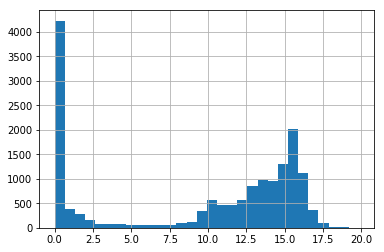

In [20]:
# Plot frequency distribution of fuel consumption
df_mod[cols_speed[0]].hist(bins=30)

In [21]:
# Get descriptive statistics
df_mod[cols_shaft].describe()

,Shaft Speed (RPM),Shaft Torque (kNm),Shaft Power (kW)
count,15901.000000,15901.000000,15901.000000
mean,50.771582,574.485107,4762.025878
std,36.699606,444.728549,4031.345934
min,-7.110332,-0.001360,5.101946
25%,0.000000,7.334197,6.960336
50%,69.651006,708.003561,5170.693709
75%,85.459148,1026.017865,9171.743147
max,88.959431,1206.091541,11150.041983


In [22]:
# Get descriptive statistics
df_mod[cols_draft].describe()

,Draft Forward (meters),Draft Aft (meters),Draft Mid-1 (meters),Draft Mid-2 (meters)
count,15901.000000,15901.000000,15901.000000,15901.000000
mean,8.110012,9.593966,8.850154,8.864763
std,2.564120,1.735524,2.119939,2.103036
min,1.761927,6.477834,5.264249,5.681231
25%,5.789762,7.957721,6.837534,6.852491
50%,7.377556,8.926435,8.205208,8.223908
75%,10.945935,11.553527,11.275325,11.289593
max,13.136587,12.589208,12.132386,12.127948


In [23]:
# Get descriptive statistics
df_mod[cols_main].describe()

,Main Engine Fuel Consumption (MT/day),Main Engine Using HFO (bool),Main Engine Using MGO (bool)
count,15901.000000,15901.000000,15901.000000
mean,17.389155,0.824980,0.175020
std,20.803470,0.379997,0.379997
min,-22.517517,0.000000,0.000000
25%,0.000000,1.000000,0.000000
50%,16.237220,1.000000,0.000000
75%,39.887646,1.000000,0.000000
max,49.138823,1.000000,1.000000


In [24]:
# Get descriptive statistics
df_mod[cols_speed].describe()

,Speed Over Ground (knots),Speed Through Water (knots),Heading (degrees),Rudder Angle (degrees)
count,15901.000000,15901.000000,15901.000000,15901.000000
mean,9.291079,9.205478,183.725273,324.326584
std,6.564412,6.550611,101.721818,104.491694
min,0.000000,-0.812132,-164.643903,0.000639
25%,0.426153,0.373527,89.038888,357.509991
50%,12.349321,12.410366,207.297326,358.606309
75%,15.091199,15.083093,273.919349,359.116573
max,19.844884,17.186902,359.824424,359.999195


In [25]:
# Get descriptive statistics
df_mod[cols_wind].describe()

,Weather Service Apparent Wind Speed (knots),Weather Service Apparent Wind Direction (degrees from bow),Weather Service True Wind Speed (knots),Weather Service True Wind Direction (degrees from north)
count,15901.000000,15901.000000,15901.000000,15901.000000
mean,14.707825,4.723314,11.939625,187.373020
std,8.622778,114.907722,6.382812,113.156494
min,0.000000,-358.561592,0.000000,0.000568
25%,7.985934,-38.661260,7.263788,78.611944
50%,13.273304,-0.576413,11.279096,197.041970
75%,20.305735,37.342207,15.825683,291.768010
max,51.955335,416.129827,40.845838,359.997076


In [26]:
# Get descriptive statistics
df_mod[cols_wave].describe()

,Weather Service Wind Wave Significant Height (meters),Weather Service Wind Wave Period (seconds),Weather Service Wind Wave Direction (degrees from north)
count,15901.000000,15901.000000,15901.000000
mean,0.324368,1.286013,36.122370
std,0.801328,2.773255,85.707869
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,6.323284,13.873590,357.472397


In [27]:
# Get descriptive statistics
df_mod[cols_sea].describe()

,Weather Service Temperature (celsius),Weather Service Sea Current Direction (degrees from north),Weather Service Sea Current Speed (knots),Water Depth (meters)
count,15901.000000,15901.000000,15901.000000,15901.000000
mean,21.255731,113.679066,0.252710,20.518930
std,7.530850,115.971721,0.392698,46.672426
min,0.272389,0.000000,0.000000,0.000000
25%,16.526901,0.000000,0.000000,0.000000
50%,22.750682,80.043012,0.119459,0.000000
75%,26.889856,209.652689,0.327714,13.997925
max,52.559168,359.999716,3.184603,326.803230


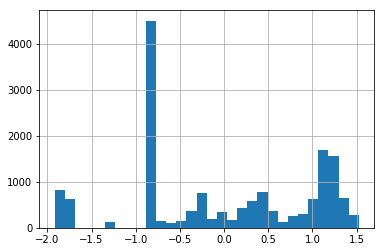

In [28]:
df_mod['Z Score'] = stats.zscore(df_mod[cols_main[1]], axis = 0)
df_mod['Z Score'].hist(bins=30)

### Outliers

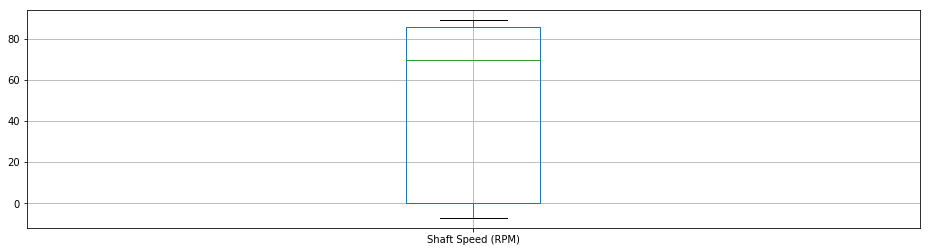

In [29]:
# Check for outliers
plt.figure("Distribution", figsize=(16,4))
df_mod[cols_shaft[0:1]].boxplot()

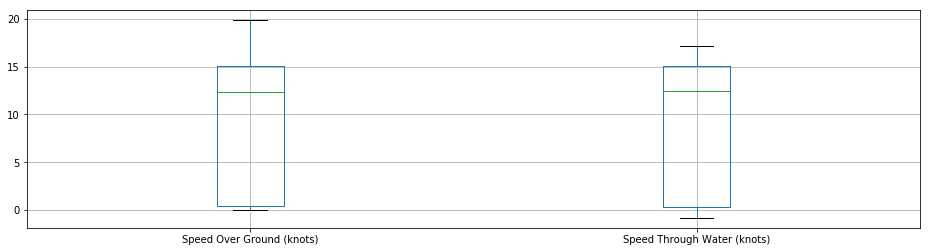

In [30]:
# Check for outliers
plt.figure("Distribution", figsize=(16,4))
df_mod[cols_speed[0:2]].boxplot()

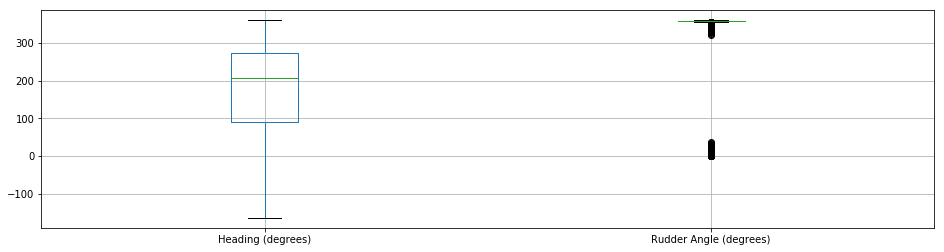

In [31]:
# Check for outliers
plt.figure("Distribution", figsize=(16,4))
df_mod[cols_speed[2:4]].boxplot()

(array([1, 2, 3, 4]), <a list of 4 Text xticklabel objects>)

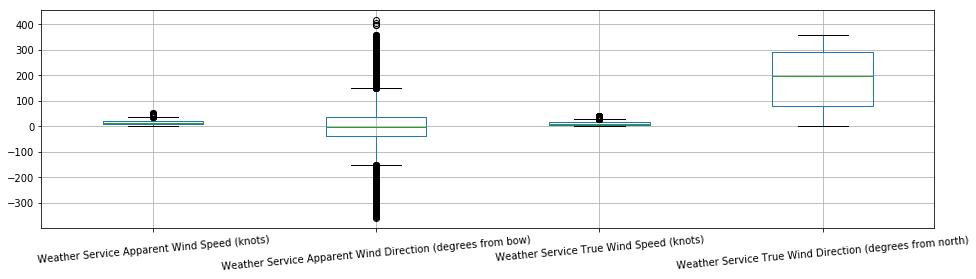

In [32]:
# Check for outliers
plt.figure("Distribution", figsize=(16,4))
df_mod[cols_wind].boxplot()
plt.xticks(rotation=5)

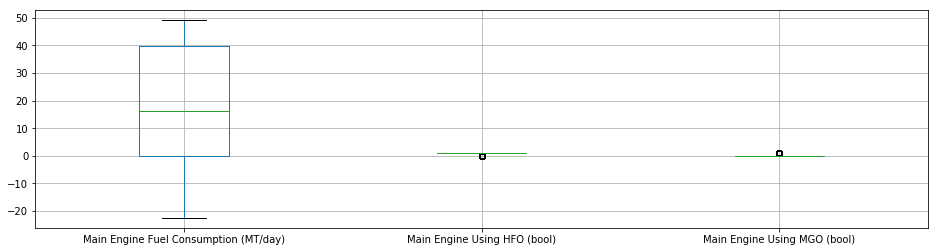

In [33]:
# Check for outliers
plt.figure("Distribution", figsize=(16,4))
df_mod[cols_main].boxplot()

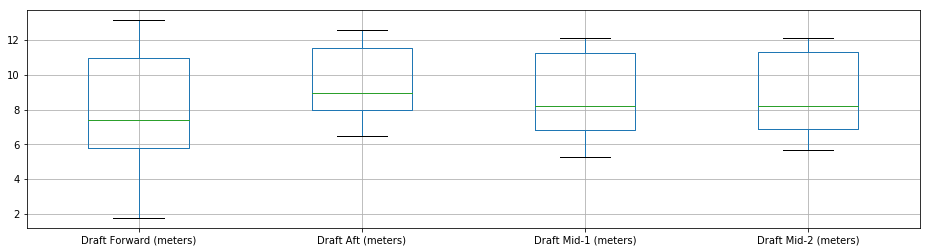

In [34]:
# Check for outliers
plt.figure("Distribution", figsize=(16,4))
df_mod[cols_draft].boxplot()

(array([1, 2, 3, 4]), <a list of 4 Text xticklabel objects>)

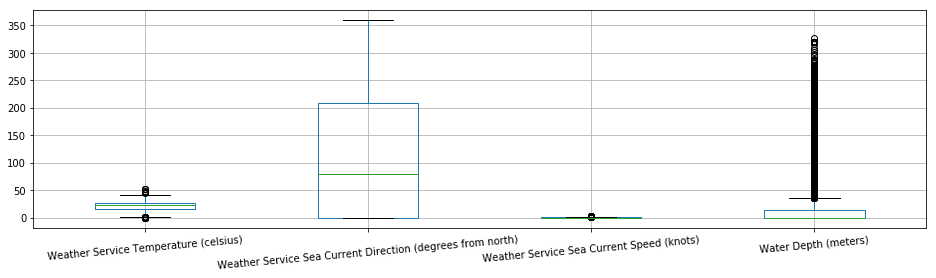

In [35]:
# Check for outliers
plt.figure("Distribution", figsize=(16,4))
df_mod[cols_sea].boxplot()
plt.xticks(rotation=5)

(array([1, 2, 3]), <a list of 3 Text xticklabel objects>)

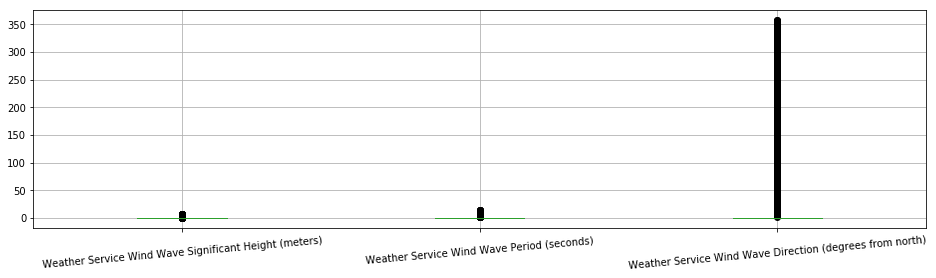

In [36]:
# Check for outliers
plt.figure("Distribution", figsize=(16,4))
df_mod[cols_wave].boxplot()
plt.xticks(rotation=5)

34.23806006893156
8.004190    1
8.008478    1
8.008509    1
8.009272    1
8.051637    1
Name: Speed Over Ground (knots), dtype: int64


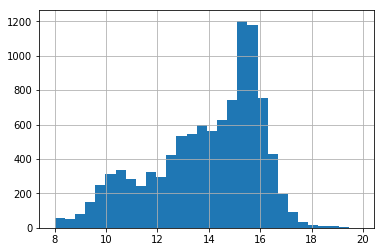

In [37]:
# Drop records with shaft speed less than 40 RPM ~ 0.64% of records
cutoff = 8
print(df_mod[df_mod[cols_speed[0]] <= cutoff].shape[0] / n_records * 100)
df_mod = df_mod.drop(df_mod[df_mod[cols_speed[0]] <= cutoff].index)
print(df_mod[cols_speed[0]].value_counts().sort_index().head())
df_mod[cols_speed[0]].hist(bins=30)

15.109551944854752
16.002908    1
16.007128    1
16.008725    1
16.008818    1
16.012017    1
Name: Main Engine Fuel Consumption (MT/day), dtype: int64


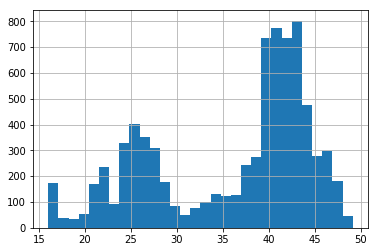

In [38]:
# Drop records with fuel consumption in lowest quintile (less than 8 MT/day) ~ 40.6% of records
cutoff = 16
print(df_mod[df_mod[cols_main[1]] <= cutoff].shape[0] / n_records * 100)
df_mod = df_mod.drop(df_mod[df_mod[cols_main[1]] <= cutoff].index)
print(df_mod[cols_main[1]].value_counts().sort_index().head())
df_mod[cols_main[1]].hist(bins=30)

0.0
44.406645    1
49.636420    1
49.736342    1
49.741726    1
50.255944    1
Name: Shaft Speed (RPM), dtype: int64


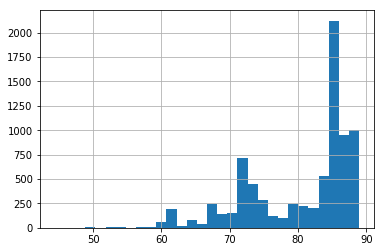

In [39]:
# Drop records with shaft speed less than 40 RPM ~ 0.64% of records
cutoff = 40
print(df_mod[df_mod[cols_shaft[0]] <= cutoff].shape[0] / n_records * 100)
df_mod = df_mod.drop(df_mod[df_mod[cols_shaft[0]] <= cutoff].index)
print(df_mod[cols_shaft[0]].value_counts().sort_index().head())
df_mod[cols_shaft[0]].hist(bins=30)

# Exploratory Data Analysis

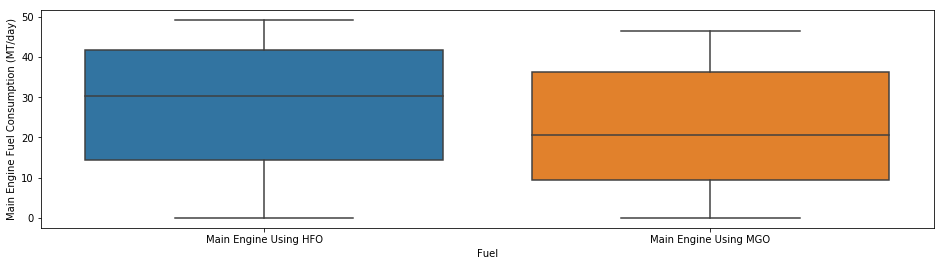

In [40]:
# Plot fuel consumption by fuel source
plt.figure('Fuel Source', figsize=(16,4))
sns.boxplot(x='Fuel', y=cols_main[1], data=df_fuel)

In [41]:
# Investigate multi-collinearity of shaft sensors (Power = Speed x Torque x unit conversion)
corr_shaft = df_mod[cols_shaft].corr()
corr_shaft

,Shaft Speed (RPM),Shaft Torque (kNm),Shaft Power (kW)
Shaft Speed (RPM),1.000000,0.965906,0.978364
Shaft Torque (kNm),0.965906,1.000000,0.995922
Shaft Power (kW),0.978364,0.995922,1.000000


In [42]:
# Investigate multi-collinearity of wind sensors
corr_wind = df_mod[cols_wind].corr()
corr_wind

,Weather Service Apparent Wind Speed (knots),Weather Service Apparent Wind Direction (degrees from bow),Weather Service True Wind Speed (knots),Weather Service True Wind Direction (degrees from north)
Weather Service Apparent Wind Speed (knots),1.000000,0.025311,0.350759,0.097590
Weather Service Apparent Wind Direction (degrees from bow),0.025311,1.000000,0.074318,0.202393
Weather Service True Wind Speed (knots),0.350759,0.074318,1.000000,0.073750
Weather Service True Wind Direction (degrees from north),0.097590,0.202393,0.073750,1.000000


In [43]:
# Investigate multi-collinearity of speed and heading sensors
corr_speed = df_mod[cols_speed].corr()
corr_speed

,Speed Over Ground (knots),Speed Through Water (knots),Heading (degrees),Rudder Angle (degrees)
Speed Over Ground (knots),1.000000,0.901959,-0.039801,0.112036
Speed Through Water (knots),0.901959,1.000000,-0.011400,0.125650
Heading (degrees),-0.039801,-0.011400,1.000000,0.166205
Rudder Angle (degrees),0.112036,0.125650,0.166205,1.000000


# Feature Engineering

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c2582a828>,
      dtype=object)

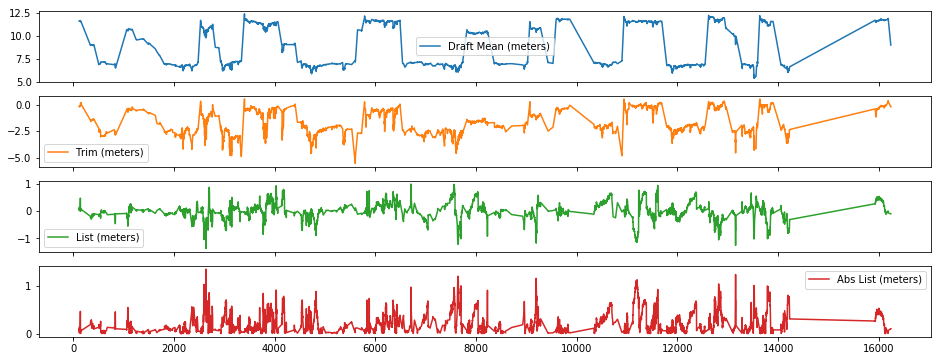

In [44]:
# Engineer features for mean draft, trim (aft heavy), list and positive list (possible nonlinear relationship)
df_mod['Draft Mean (meters)'] = df_mod[cols_draft].mean(axis=1)
df_mod['Trim (meters)']       = df_mod[cols_draft[0]] - df_mod[cols_draft[1]]
df_mod['List (meters)']       = df_mod[cols_draft[2]] - df_mod[cols_draft[3]]
df_mod['Abs List (meters)']   = df_mod['List (meters)'].abs()

# Plot time series
fig_draft_fe, axes_draft_fe = plt.subplots(4,1, figsize=(16,4*1.5), sharex=True)
df_mod[['Draft Mean (meters)',
        'Trim (meters)',
        'List (meters)',
        'Abs List (meters)']].plot(subplots=True, ax=axes_draft_fe)

In [45]:
# Engineer features for apparent sea current direction and speed
col         = 'Weather Service Apparent Sea Current Direction (degrees from bow)'
df_mod[col] = df_mod[cols_speed[2]] - df_mod[cols_sea[1]]

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c26418cf8>,
      dtype=object)

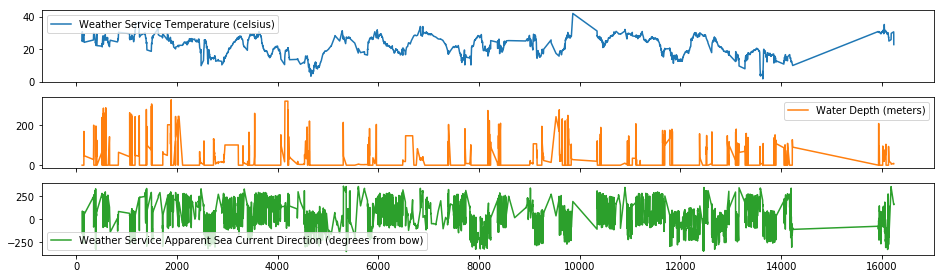

In [46]:
# Plot time series
fig_sea_fe, axes_sea_fe = plt.subplots(3,1, figsize=(16,3*1.5), sharex=True)
df_mod[[cols_sea[0],
        cols_sea[3],
      'Weather Service Apparent Sea Current Direction (degrees from bow)']].plot(subplots=True, ax=axes_sea_fe)

# Clean Data

In [47]:
# Reset DataFrame index after dropping records
df_mod = df_mod.reset_index().drop('index',axis=1)

# 1. Machine Learning Regression Model

In [48]:
df_regr = df_mod[[
    'Main Engine Fuel Consumption (MT/day)',
    'Main Engine Using MGO (bool)',
    'Draft Mean (meters)',
    'Trim (meters)',
    'List (meters)',
    'Abs List (meters)',
    'Shaft Speed (RPM)',
    'Shaft Torque (kNm)',
    'Speed Through Water (knots)',
    'Heading (degrees)',
    'Rudder Angle (degrees)',
    'Weather Service Apparent Wind Speed (knots)',
    'Weather Service Apparent Wind Direction (degrees from bow)',
    'Weather Service Temperature (celsius)',
    'Weather Service Sea Current Direction (degrees from north)',
    'Weather Service Sea Current Speed (knots)',
    'Water Depth (meters)',
    'Weather Service Apparent Sea Current Direction (degrees from bow)']]
df_regr.head()

,Main Engine Fuel Consumption (MT/day),Main Engine Using MGO (bool),Draft Mean (meters),Trim (meters),List (meters),Abs List (meters),Shaft Speed (RPM),Shaft Torque (kNm),Speed Through Water (knots),Heading (degrees),Rudder Angle (degrees),Weather Service Apparent Wind Speed (knots),Weather Service Apparent Wind Direction (degrees from bow),Weather Service Temperature (celsius),Weather Service Sea Current Direction (degrees from north),Weather Service Sea Current Speed (knots),Water Depth (meters),Weather Service Apparent Sea Current Direction (degrees from bow)
0,41.473078,0,11.623998,-0.150119,0.097050,0.097050,85.903143,1040.493340,15.807160,99.148003,358.071607,10.406759,-3.418403,25.161969,248.353210,0.237554,0.0,-149.205207
1,41.249985,0,11.621319,-0.139044,0.079386,0.079386,85.887671,1035.687927,15.753783,86.778544,359.080607,8.222903,-4.492690,25.328048,248.870589,0.241738,0.0,-162.092045
2,41.221734,0,11.623694,-0.139068,0.061082,0.061082,85.908202,1035.380715,15.852655,86.329889,358.628799,6.574401,-18.524343,25.932167,0.000000,0.000000,0.0,86.329889
3,41.097703,0,11.626613,-0.154088,0.059839,0.059839,85.909091,1032.674218,16.067271,87.081565,358.557335,7.229827,-0.629331,29.833849,0.000000,0.000000,0.0,87.081565
4,41.410789,0,11.621324,-0.158044,0.030999,0.030999,85.890631,1040.666744,15.917059,85.922376,359.203618,8.626424,10.589120,30.717468,0.000000,0.000000,0.0,85.922376


In [49]:
y = df_regr['Main Engine Fuel Consumption (MT/day)']
X = df_regr.drop('Main Engine Fuel Consumption (MT/day)',axis=1)
regr = sm.OLS(y,X).fit()
regr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      OLS Regression Results                                     
=================================================================================================
Dep. Variable:     Main Engine Fuel Consumption (MT/day)   R-squared:                       0.999
Model:                                               OLS   Adj. R-squared:                  0.999
Method:                                    Least Squares   F-statistic:                 8.979e+05
Date:                                   Tue, 30 Jul 2019   Prob (F-statistic):               0.00
Time:                                           04:02:35   Log-Likelihood:                -10060.
No. Observations:                                   7883   AIC:                         2.015e+04
Df Residuals:                                       7867   BIC:                         2.026e+04
Df Model:                                             16                                         
Covariance Type:                               nonrobust                                         
=====================================================================================================================================
                                                                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------
Main Engine Using MGO (bool)                                         -0.6645      0.044    -15.065      0.000      -0.751      -0.578
Draft Mean (meters)                                                  -0.0292      0.011     -2.561      0.010      -0.052      -0.007
Trim (meters)                                                         0.5758      0.018     32.454      0.000       0.541       0.611
List (meters)                                                        -0.7686      0.036    -21.374      0.000      -0.839      -0.698
Abs List (meters)                                                    -0.0055      0.049     -0.113      0.910      -0.101       0.090
Shaft Speed (RPM)                                                    -0.3470      0.006    -58.246      0.000      -0.359      -0.335
Shaft Torque (kNm)                                                    0.0620      0.000    348.992      0.000       0.062       0.062
Speed Through Water (knots)                                           0.5409      0.020     27.617      0.000       0.503       0.579
Heading (degrees)                                                    -0.0002    7.9e-05     -2.601      0.009      -0.000   -5.06e-05
Rudder Angle (degrees)                                               -0.0002      0.000     -1.910      0.056      -0.000    5.77e-06
Weather Service Apparent Wind Speed (knots)                          -0.0306      0.001    -21.262      0.000      -0.033      -0.028
Weather Service Apparent Wind Direction (degrees from bow)           -0.0006      0.000     -5.390      0.000      -0.001      -0.000
Weather Service Temperature (celsius)                                -0.0370      0.002    -19.269      0.000      -0.041      -0.033
Weather Service Sea Current Direction (degrees from north)           -0.0001   7.13e-05     -1.604      0.109      -0.000    2.54e-05
Weather Service Sea Current Speed (knots)                            -0.0665      0.025     -2.661      0.008      -0.115      -0.018
Water Depth (meters)                                                 -0.0011      0.000     -5.454      0.000      -0.002      -0.001
Weather Service Apparent Sea Current Direction (degrees from bow) -9.118e-05   4.84e-05     -1.885      0.059      -0.000    3.65e-06
==============================================================================
Omnibus:                     1739.526   Durbin-Watson:                   0.264
Prob(Omnibus):                  0.00

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


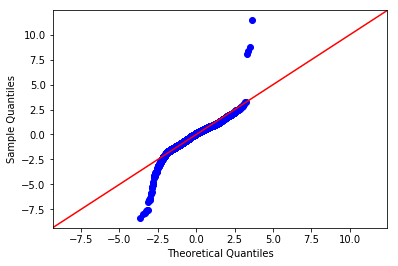

In [50]:
residuals = regr.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
fig.show()

# 2. Speed Scores

# 3. Report

# 4. Sensor Drift